### Generate DroneDetect Features
- notebook to load data (currently: DroneDetect dataset)
- generate RF-based features: PSD, spectrograms in array and image format


In [1]:
import os
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import os
from sklearn.model_selection import train_test_split
from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis
from scipy.signal import get_window
import scipy.fftpack as fft
from scipy import signal
import matplotlib.pyplot as plt
from datetime import date
from tqdm import tqdm
from loading_functions import *

from feat_gen_functions import *

In [2]:
# # Reload modules for testing
# import importlib
# import helper_functions
# importlib.reload(helper_functions)
# from helper_functions import *

In [3]:
# Data paths
from file_paths import *
# DroneDetect
main_folder = dronedetect_raw_path # data path on mp-gpu-desktop06
sub_folders = os.listdir(main_folder)

# Dataset Info
fs = 60e6 #60 MHz
bandwidth = 28e6 # 28MHz
center_freq = 2.43e9


In [ ]:
# Specifications on what features to generate
n_per_seg = 256 # length of each segment (powers of 2)
n_overlap_spec = 120
psd_win_type = 'hamming' # make ends of each segment match
spec_han_window = np.hanning(n_per_seg)
t_seg = 20 # sample length in milliseconds
feature_to_save = ['SPEC'] # what features to generate and save: SPEC or PSD, or RAW
format_to_save = ['ARR'] # IMG or ARR
inteference_folders = ['CLEAN','WIFI', 'BLUE', 'BOTH'] # options: ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
to_add = True # to add to existing directory

# Image properties
dim_px = (224, 224) # dimension of image pixels
dpi = 100

# RAW data downsample: length
iq_samp_len = 10000 # 10000 is the input lengths 

# data saving folders
features_folder = dronedetect_feat_path
date_string = date.today()
# folder naming: DATATYPE_FEAT_NFFT_SAMPLELENGTH
arr_spec_folder = "ARR_SPEC_"+str(n_per_seg)+"_"+str(t_seg)
arr_psd_folder = "ARR_PSD_"+str(n_per_seg)+"_"+str(t_seg)
img_spec_folder = "IMG_SPEC_"+str(n_per_seg)+"_"+str(t_seg)
img_psd_folder = "IMG_PSD_"+str(n_per_seg)+"_"+str(t_seg)
iq_folder = 'IQ'+'_'+str(iq_samp_len)+"_"+str(t_seg)

# check if this set of parameters already exists
existing_folders = os.listdir(features_folder)

# check if each of the 4 folders exist
sa_save = False   #spec array
si_save = False   #spec imag
pa_save = False   #psd array
pi_save = False   #psd imag
iq_save = False   #iq raw
if 'SPEC' in feature_to_save:
    if 'ARR' in format_to_save:
        if arr_spec_folder not in existing_folders or to_add:
            try:
                os.mkdir(features_folder+arr_spec_folder)
            except:
                print('folder already exist - adding')
            sa_save = True
            print('Generating SPEC in ARRAY format')
        else:
            print('Spec Arr folder already exists')
    if 'IMG' in format_to_save:
        if img_spec_folder not in existing_folders or to_add:
            try:
                os.mkdir(features_folder+img_spec_folder)
            except:
                print('folder already exist - adding')
            si_save = True
            print('Generating SPEC in IMAGE format')
        else:
            print('Spec Arr folder already exists')
if 'PSD' in feature_to_save:
    if 'ARR' in format_to_save:
        if arr_psd_folder not in existing_folders or to_add:
            try:
                os.mkdir(features_folder+arr_psd_folder)
            except:
                print('folder already exist - adding')
            pa_save = True
            print('Generating PSD in ARRAY format')
        else:
            print('PSD Arr folder already exists')
    if 'IMG' in format_to_save:
        if img_psd_folder not in existing_folders or to_add:
            try:
                os.mkdir(features_folder+img_psd_folder)
            except:
                print('folder already exist - adding')
            pi_save = True
            print('Generating PSD in IMAGE format')
        else:
            print('PSD Arr folder already exists')
if 'RAW' in feature_to_save:
    if iq_folder in existing_folders or to_add:
        try:
            os.mkdir(features_folder+iq_folder)
        except:
            print('RAW IQ folder already exists')
        iq_save = True
            
if all([not sa_save, not si_save, not pa_save, not pi_save, not iq_save]):
    print('Features Already Exist - Do Not Generate')
else:
    ## Generate features

    # loop through all files
    for sf in inteference_folders: # options: ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
        print('CURRENT FOLDER: ', sf)

        drone_folders = os.listdir(main_folder+sf+'/')
        for df in drone_folders:
            print('     subfolder:', df)
            # reset lists -  to save memory
            DRONES = []
            CONDS =[]
            INTS = [] # interferences: 00 for a clean signal, 01 for Bluetooth only, 10 for Wi-Fi only and 11 for Bluetooth and Wi-Fi interference concurrently.

            # features
            F_PSD = []
            F_SPEC = []
            F_IQ = []

            files = os.listdir(main_folder+sf+'/'+df+'/')
            
            #labels (from folder name)
            drone_name = df[:3]
            cond_name = df[4:]

            for fi in tqdm(files):
                d_split, _ = load_dronedetect_raw(main_folder+sf+'/'+df+'/'+fi, t_seg)
                
                # labels (from file name)
                fi_number = fi[-6:-4]
                int_name = fi[4:6]
                for i in range(len(d_split)): # for each split based on t_seg

                    d_complex = d_split[i]

                    # save labels
                    DRONES.append(drone_name)
                    CONDS.append(cond_name)
                    INTS.append(int_name)
                    
                    # if save raw data
                    if iq_save:
                        t = np.arange(0, len(d_complex))
                        f_real = interpolate.interp1d(t, d_complex.real)
                        f_imag = interpolate.interp1d(t, d_complex.imag)
                        tt = np.linspace(0, len(d_complex)-1, num=iq_samp_len)

                        d_iq = np.stack((f_real(tt), f_imag(tt)), axis=0)
                        F_IQ.append(d_iq)

                    # calculate PSD
                    if pa_save or pi_save:
                        fpsd, Pxx_den = signal.welch(d_complex, fs, window=psd_win_type, nperseg=n_per_seg)
                        if pa_save:
                            F_PSD.append(Pxx_den)
#                             F_PSD_freq.append(fpsd)
                        
                        if pi_save:
                            save_psd_image(features_folder, img_psd_folder, drone_name, 
                                           cond_name, int_name, fi_number, i, Pxx_den, dim_px, dpi)

                    # calculate spectrogram
                    if sa_save or si_save:
#                         fspec, t, Sxx = signal.spectrogram(d_complex, fs, window=win_type, nperseg=n_per_seg, noverlap =0) ## using minimal overlap
                        if si_save: # set up fig properties if saving images
                            plt.clf()
                            fig,ax = plt.subplots(1, figsize=(dim_px[0]/dpi, dim_px[1]/dpi), dpi=dpi)
                            fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
                            ax.axis('tight')
                            ax.axis('off')
                        
                        spec, _, _, _ = plt.specgram(d_complex, NFFT=n_per_seg, Fs=fs, window=spec_han_window, 
                                          noverlap=n_overlap_spec, sides='onesided')
                        if si_save:
                            save_spec_image_fig(features_folder, img_spec_folder, 
                                                drone_name, cond_name, int_name, fi_number, i, fig, dpi)
                        if sa_save:
                            F_SPEC.append(interpolate_2d(spec, (224,224))) # reshape to square?
#                         F_SPEC_freq.append(fspec)
#                         F_SPEC_time.append(t)

                    # save the images 
    #                 save_spec_image(features_folder, img_spec_folder, drone_name, 
    #                                 cond_name, int_name, fi_number, i, fspec, t, Sxx)

    #                 # save the images 
    #                 save_psd_image(features_folder, img_psd_folder, drone_name, 
    #                                 cond_name, int_name, fi_number, i, fpsd, Pxx_den)

            # save data array
            if sa_save:
                save_array_detect(features_folder+arr_spec_folder, F_SPEC, DRONES, CONDS, INTS, 'SPEC'+"_"+df, sf, n_per_seg)
            if pa_save:
                save_array_detect(features_folder+arr_psd_folder, F_PSD, DRONES, CONDS, INTS, 'PSD'+"_"+df, sf, n_per_seg)
            if iq_save:
                save_array_detect(features_folder+iq_folder, F_IQ, DRONES, CONDS, INTS, 'RAW'+"_"+df, sf, '')



Generating SPEC in ARRAY format
CURRENT FOLDER:  CLEAN
     subfolder: AIR_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.67s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_AIR_FY_256
     subfolder: MP1_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.26s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MP1_ON_256
     subfolder: MIN_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.91s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MIN_FY_256
     subfolder: PHA_FY


0it [00:00, ?it/s]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_PHA_FY_256
     subfolder: MP2_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.27s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MP2_ON_256
     subfolder: MIN_HO


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.58s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MIN_HO_256
     subfolder: AIR_HO


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.09s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_AIR_HO_256
     subfolder: MP1_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.65s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MP1_FY_256
     subfolder: DIS_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.74s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_DIS_FY_256
     subfolder: MIN_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.74s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MIN_ON_256
     subfolder: DIS_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.02s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_DIS_ON_256
     subfolder: INS_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.41s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_INS_FY_256
     subfolder: INS_HO


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.49s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_INS_HO_256
     subfolder: MP2_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.46s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MP2_FY_256
     subfolder: MP1_HO


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.36s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MP1_HO_256
     subfolder: MP2_HO


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:01<00:00, 24.37s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_MP2_HO_256
     subfolder: PHA_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.38s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_PHA_ON_256
     subfolder: PHA_HO


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.40s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_PHA_HO_256
     subfolder: INS_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_INS_ON_256
     subfolder: AIR_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.35s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/CLEAN_SPEC_AIR_ON_256
CURRENT FOLDER:  WIFI
     subfolder: AIR_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [01:21<00:00, 16.33s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/WIFI_SPEC_AIR_FY_256
     subfolder: MP1_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:41<00:00, 44.30s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/WIFI_SPEC_MP1_ON_256
     subfolder: MIN_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:27<00:00, 41.45s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/WIFI_SPEC_MIN_FY_256
     subfolder: PHA_FY


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.52s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/WIFI_SPEC_PHA_FY_256
     subfolder: MP2_ON


100%|███████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.22s/it]


/home/kzhou/main/Features/ARR_SPEC_256_20/WIFI_SPEC_MP2_ON_256
     subfolder: MIN_HO


 20%|███████████████                                                            | 1/5 [00:33<02:13, 33.44s/it]

In [16]:
d_iq = np.stack((d_complex.real, d_complex.imag), axis=0)

In [17]:
d_iq.shape

(2, 1200000)

In [23]:
10000/1200000

0.008333333333333333

In [22]:
d1 = d_iq[0]

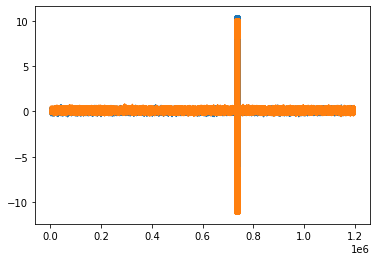

In [21]:
plt.plot(d_iq[0])
plt.plot(d_iq[1])

In [24]:
t = np.arange(0, len(d1))
f = interpolate.interp1d(t,d1)
tt = np.linspace(0, len(d1)-1, num=10000)

dd = f(tt)


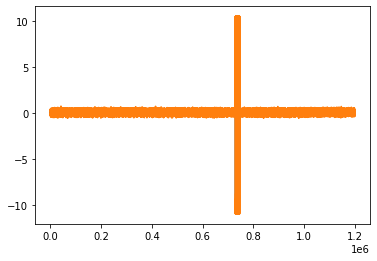

In [27]:
plt.plot(tt, dd)
plt.plot(t, d1)


------------------------------------------------------------------------

## Load Files test

In [46]:
from loading_functions import *

In [47]:
feat_folder = '../Features/'
feat_name = 'PSD'
# datestr = '2022-06-29'
n_per_seg = 512
interferences = ['WIFI']
seg_len = 200
output_feat = 'drones'
# (feat_folder, feat_name, seg_len, n_per_seg, output_feat, interferences)
Xs_arr, y_arr = load_dronedetect_features(feat_folder, feat_name, seg_len, n_per_seg, output_feat, interferences)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 3199.04it/s]


In [35]:
Xs_arr.shape

(1000, 512)

## Plot as images test

In [48]:
import importlib
# import loading_functions
# importlib.reload(loading_functions)

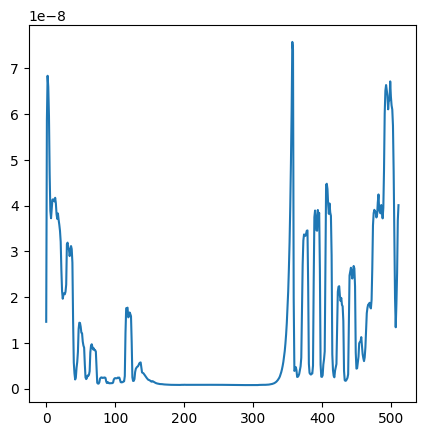

In [49]:
sample_to_plot = 0
helper_functions.plot_image(Xs_arr[sample_to_plot], dim=(224,224), dpi=100)